In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
def adjust_p(p, fpr, tpr):
    return (p-fpr)/(tpr-fpr)

adjust_p(0.2,0.0001,0.999)

0.20012013214535992

In [96]:
rel = pd.read_csv("/home/sarah/projects/nets_climatebert/data/2023-04-06_test_predicted_relevant_Hyperparam_3fold.csv")
rel_pred = pd.read_csv("/home/sarah/projects/nets_climatebert/data/2023-04-11_relevant_predicted_Hyperparam.csv")

In [67]:
tp = []
tn = []
fn = []
fp = []
for seed in range(3):
    df = rel.loc[rel["seed"]==seed]
    tp.append(len(df.loc[ (df["label_3"]==1) & (df["predProba"]>=0.5)]))
    tn.append(len(df.loc[ (df["label_3"]==0) & (df["predProba"]<0.5)]))
    fn.append(len(df.loc[ (df["label_3"]==1) & (df["predProba"]<0.5)]))
    fp.append(len(df.loc[ (df["label_3"]==0) & (df["predProba"]>=0.5)]))
tp_mean = np.mean(tp)
fn_mean = np.mean(fn)
fp_mean = np.mean(fp)

tp_mean = np.sum(tp)
fn_mean = np.sum(fn)
fp_mean = np.sum(fp)

In [68]:
prec = tp_mean/(tp_mean+fp_mean)
rec = tp_mean/(tp_mean+fn_mean)
f1 = 2*(prec * rec)/(prec+rec)
print(prec, rec, f1)


0.8813559322033898 0.9339513325608343 0.9068917018284106


In [69]:
# confidence intervals
prec_l, prec_h = proportion_confint(
    tp_mean, 
    (fp_mean+tp_mean),
    alpha=0.05, method='agresti_coull'
)
sigma_prec = prec_h-prec_l
rec_l, rec_h = proportion_confint(
    tp_mean, 
    (fn_mean+tp_mean),
    alpha=0.05, method='agresti_coull'
)
sigma_rec = rec_h-rec_l
print(sigma_rec, sigma_prec)

0.016617407919235383 0.020977773261764643


In [105]:
# error propagation to get confidence interval of F1 score 
# F1 = 2 * prec*rec/(prec+rec)
# sigma²(F1) = |partial F/partial prec|²*sigma_prec² + |partial F/partial rec|²*sigma_rec²
# sigma²(F1) = 2 * ((rec)²/(rec+prec)⁴sigma_prec² + (prec)²/(rec+prec)⁴sigma_prec²*sigma_rec²

sigma_f1 = np.sqrt(2* ((rec)**4/(rec+prec)*sigma_prec**2 + (prec)**4/(rec+prec)*sigma_rec**2   ))

In [106]:
sigma_f1

0.023504534844876572

In [104]:
# counts - upper/lower bound
N_pred = len(rel_pred.loc[rel_pred.pred_relevance>=0.5])
N_tot = len(rel_pred)
print("Predicted count (including from paper exlcuded classes such as CCS, algae etc)")
print(N_pred)


tpr = tp_mean / (tp_mean + fn_mean)
tpr_l, tpr_h = proportion_confint(
    tp_mean, 
    (tp_mean + fn_mean),
    alpha=0.05, method='agresti_coull'
)
fpr = fp_mean / (fp_mean + tn_mean)
fpr_l, fpr_h = proportion_confint(
    fp_mean, 
    (fp_mean + tn_mean),
    alpha=0.05, method='agresti_coull'
)
# prob
p = N_pred/N_tot

p_acc = (p - fpr) /(tpr -fpr)
p_acc_l = (p - fpr_h) /(tpr_h -fpr_h)
p_acc_h = (p - fpr_l) /(tpr_l -fpr_l)

print("Adjusted range of counts")
print(p_acc_l*N_tot, p_acc*N_tot, p_acc_h*N_tot)

print(tpr, fpr)

Predicted count (including from paper exlcuded classes such as CCS, algae etc)
44780
Adjusted range of counts
20150.81954382809 24138.75012571455 27752.184546800865
0.9339513325608343 0.4854586129753915


In [100]:
(p_acc_h*N_tot - p_acc_l*N_tot)/2 

3800.682501486388

### Technology classifier

In [7]:
N = 44780

In [84]:
df05 = pd.read_excel('data/TechClassifier_Performance_05lDecBoundary.xlsx')
df = pd.read_excel('data/TechClassifier_Performance_optimalDecBoundary.xlsx')
df = df[df['predicted counts']>0]
df = df.sort_values('Number of Samples').reset_index(drop=True)
df

,Unnamed: 0,Main Focus,Number of Samples,F1 - mean,F1 - std,ROC - mean,ROC - std,truePos - mean,truePos - std,falsePos - mean,falsePos - std,trueNeg - mean,trueNeg - std,falseNeg - mean,falseNeg - std,predicted counts
0,14,Other technologies,7,0.000000,0.000000,0.496667,0.002517,0.000000,0.000000,8.666667,6.027714,1150.000000,7.211103,2.333333,1.527525,275
1,1,Agroforestry,20,0.372333,0.206904,0.741333,0.126081,3.333333,2.516611,7.000000,1.000000,1147.666667,2.516611,3.000000,1.000000,4136
2,10,Forest Management,47,0.698000,0.172044,0.859333,0.137613,10.333333,4.163332,4.333333,1.527525,1142.000000,4.358899,4.333333,4.932883,2195
3,12,Ocean alkalinity enhancement,50,0.703333,0.172248,0.828333,0.156353,8.333333,2.886751,1.666667,1.154701,1146.000000,2.645751,5.000000,4.358899,157
4,13,Ocean fertilization & Artificial upwelling,95,0.893667,0.094733,0.931000,0.059858,26.333333,3.214550,2.000000,2.000000,1128.333333,4.041452,4.333333,4.041452,424
5,2,Algae farming,98,0.862000,0.094398,0.906000,0.074726,26.666667,10.016653,2.000000,1.732051,1127.000000,6.557439,5.333333,3.511885,1217
6,0,AR,107,0.646667,0.164491,0.776667,0.105306,14.333333,4.163332,3.000000,1.000000,1130.666667,7.023769,13.000000,9.539392,3036
7,11,General Literature on CDR/NET,116,0.724000,0.118203,0.842667,0.051228,25.000000,7.549834,7.333333,4.163332,1118.000000,2.000000,10.666667,2.516611,1007
8,16,restoration of landscapes/peats,165,0.937000,0.052048,0.965667,0.027737,50.666667,2.081666,3.333333,3.214550,1103.333333,6.027714,3.666667,3.055050,1132
9,9,Enhanced Weathering (land based),172,0.842333,0.079431,0.918667,0.045545,46.666667,13.868429,8.333333,2.309401,1098.000000,10.440307,8.000000,3.464102,493


In [87]:
df["predicted counts"].sum()

57208

In [47]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(10,100, alpha=0.05, method='agresti_coull')

(0.05348475228884133, 0.17611004627674723)

In [18]:
list(zip(proportion_confint(
    df['truePos - mean'], (df['truePos - mean'] + df['falseNeg - mean']),
    alpha=0.05, method='agresti_coull'
)))

[(0     0.308821
  1     0.103757
  2     0.767035
  3     0.335217
  4     0.426258
  5     0.828238
  6     0.699835
  7     0.741634
  8     0.889135
  9     0.952256
  10    0.819639
  11    0.955655
  dtype: float64,),
 (0     0.763220
  1     0.546894
  2     0.986411
  3     0.686168
  4     0.734046
  5     0.979672
  6     0.904070
  7     0.907172
  8     0.979491
  9     1.000000
  10    0.923299
  11    0.996994
  dtype: float64,)]

In [48]:
# https://arxiv.org/abs/2011.02552

df['tpr'] = df['truePos - mean'] / (df['truePos - mean'] + df['falseNeg - mean'])
df['tpr_l'], df['tpr_h'] = proportion_confint(
    df['truePos - mean'], 
    (df['truePos - mean'] + df['falseNeg - mean']),
    alpha=0.05, method='agresti_coull'
)
df['fpr'] = df['falsePos - mean'] / (df['falsePos - mean'] + df['trueNeg - mean'])
df['fpr_l'], df['fpr_h'] = proportion_confint(
    df['falsePos - mean'], 
    (df['falsePos - mean'] + df['trueNeg - mean']),
    alpha=0.05, method='agresti_coull'
)

df['prec'] = df['truePos - mean'] / (df['falsePos - mean'] + df['truePos - mean'])
df['prec_l'], df['prec_h'] = proportion_confint(
    df['truePos - mean'], 
    (df['falsePos - mean'] + df['truePos - mean']),
    alpha=0.05, method='agresti_coull'
)

df['recall'] = df['truePos - mean']/(df["truePos - mean"]+df["falseNeg - mean"])
df['p'] = df['predicted counts'] / N
df['p_acc'] = (df['p']-df['fpr'])/(df['tpr']-df['fpr'])
df['count_acc'] = df['p_acc'] * N

df05['recall'] = df05['truePos - mean']/(df05["truePos - mean"]+df05["falseNeg - mean"])
df05['prec'] = df05['truePos - mean'] / (df05['falsePos - mean'] + df05['truePos - mean'])

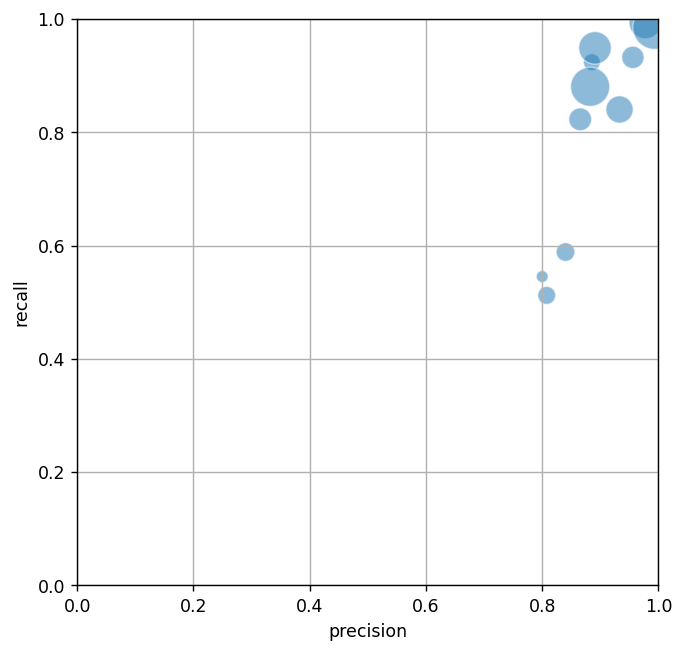

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6), dpi=125, sharey=True)
sns.scatterplot(x=df['prec'], y=df['tpr'], s=df['Number of Samples'],alpha=0.5)
ax.grid()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_ylabel('recall')
ax.set_xlabel('precision')

plt.savefig('plots/precision_recall.pdf', bbox_inches='tight')

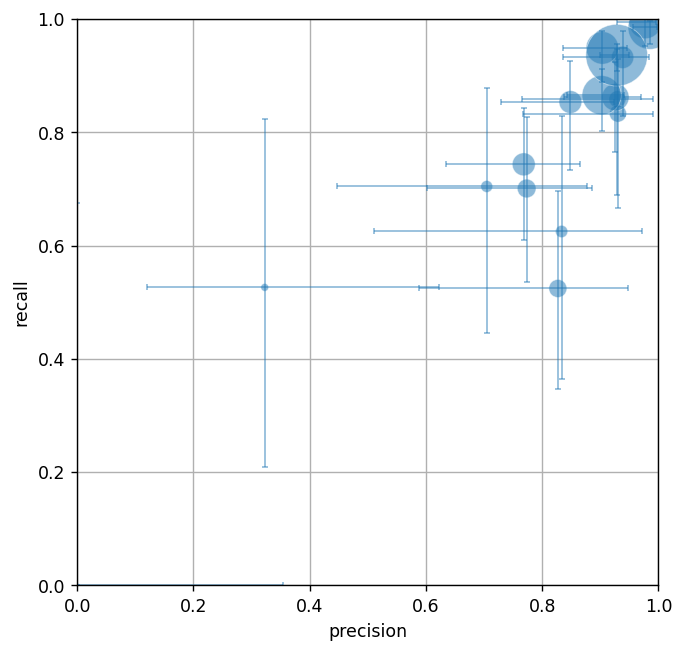

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6,6), dpi=125, sharey=True)
sns.scatterplot(x=df['prec'], y=df['tpr'], s=df['Number of Samples'],alpha=0.5)

rerr = np.zeros((2, df.shape[0]))
rerr[0,:] = df['tpr']-df['tpr_l']
rerr[1,:] = df['tpr_h']-df['tpr']

perr = np.zeros((2, df.shape[0]))
perr[0,:] = df['prec']-df['prec_l']
perr[1,:] = df['prec_h']-df['prec']

ax.errorbar(
    df['prec'], y=df['tpr'], 
    yerr=rerr, xerr=perr, fmt='none', ls='--',
    lw=1, capsize=2, alpha=0.5
)
ax.grid()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_ylabel('recall')
ax.set_xlabel('precision')

plt.savefig('plots/precision_recall_error.pdf', bbox_inches='tight')

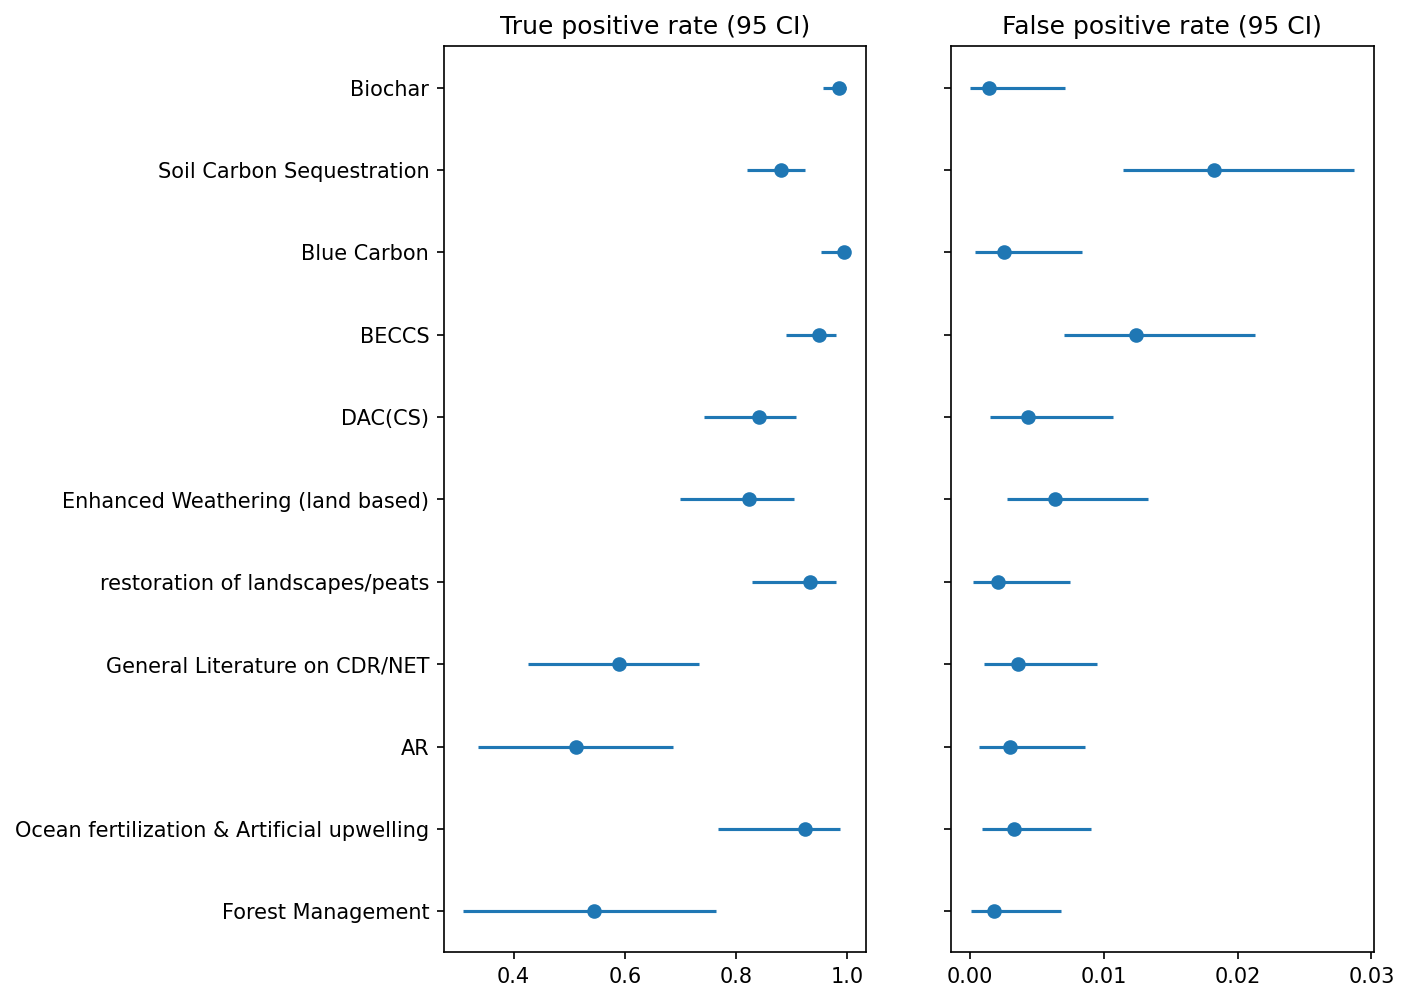

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8,8), dpi=150, sharey=True)

err = np.zeros((2, df.shape[0]))
err[0,:] = df['tpr']-df['tpr_l']
err[1,:] = df['tpr_h']-df['tpr']

axs[0].scatter(df['tpr'], df.index)
axs[0].errorbar(df['tpr'], df.index, xerr=err, fmt='none')

axs[0].set_yticks(df.index)
axs[0].set_yticklabels(df['Main Focus'])

err = np.zeros((2, df.shape[0]))
err[0,:] = df['fpr']-df['fpr_l']
err[1,:] = df['fpr_h']-df['fpr']

axs[1].scatter(df['fpr'], df.index)
axs[1].errorbar(df['fpr'], df.index, xerr=err, fmt='none')
axs[1].set_title('False positive rate (95 CI)')
axs[0].set_title('True positive rate (95 CI)')

plt.savefig('plots/tpr_fpr_error.pdf', bbox_inches='tight')

In [22]:
df = df[df['p_acc']>0].reset_index(drop=True)
df['p_acc_l'] = (df['p']-df['fpr_h'])/(df['tpr_h']-df['fpr_h'])
df['p_acc_h'] = (df['p']-df['fpr_l'])/(df['tpr_l']-df['fpr_l'])
df['p_acc_l'] = df['p_acc_l'].clip(lower=0)
df['p_acc_h'] = np.where(df['p_acc_h']<0,1,df['p_acc_h'])
df[['fpr','fpr_l','p_acc','p_acc_l','p_acc_h']]

,fpr,fpr_l,p_acc,p_acc_l,p_acc_h
0,0.001745,0.000040,0.066532,0.041168,0.122671
1,0.003244,0.000852,0.008313,0.001940,0.013112
2,0.002940,0.000679,0.096092,0.063926,0.153039
3,0.003555,0.001031,0.025865,0.012746,0.041532
4,0.002108,0.000197,0.027160,0.020484,0.032825
5,0.006327,0.002784,0.002506,0.000000,0.008020
6,0.004306,0.001446,0.013731,0.005710,0.019377
7,0.012389,0.007030,0.022769,0.012957,0.030258
8,0.002551,0.000380,0.027197,0.021336,0.030615
9,0.018248,0.011425,0.178886,0.160715,0.199310


In [23]:
err = np.zeros((2, df.shape[0]))

err[0,:] = df['count_acc'] - (df['p_acc_l']*N)
err[1,:] = (df['p_acc_h']*N) - df['count_acc'] 

err

array([[1135.77728828,  285.37991183, 1440.42981764,  587.46625596,
         298.96968319,  112.22182488,  359.15997596,  439.37089756,
         262.47403521,  813.68638829,  353.17251567],
       [2513.89764942,  214.87656684, 2550.05357681,  701.56201106,
         253.69790093,  246.93017657,  252.82929245,  335.34021515,
         153.06724668,  914.5858721 ,  534.88736204]])

In [13]:
df['p_acc_l']*N

0         0.000000
1      4398.370971
2      2029.280043
3         0.000000
4       123.602469
5       985.484688
6      3879.611257
7       497.436664
8       761.564705
9         0.000000
10      275.523199
11      323.035088
12      978.611699
13      633.188967
14     7145.612111
15    15473.152857
16    14188.026796
Name: p_acc_l, dtype: float64

In [14]:
df[['count_acc']]

,count_acc
0,8014.615385
1,7428.163780
2,2890.731160
3,147.493916
4,402.329524
5,1368.116102
6,5591.822357
7,1029.908805
8,1072.745512
9,184.014652


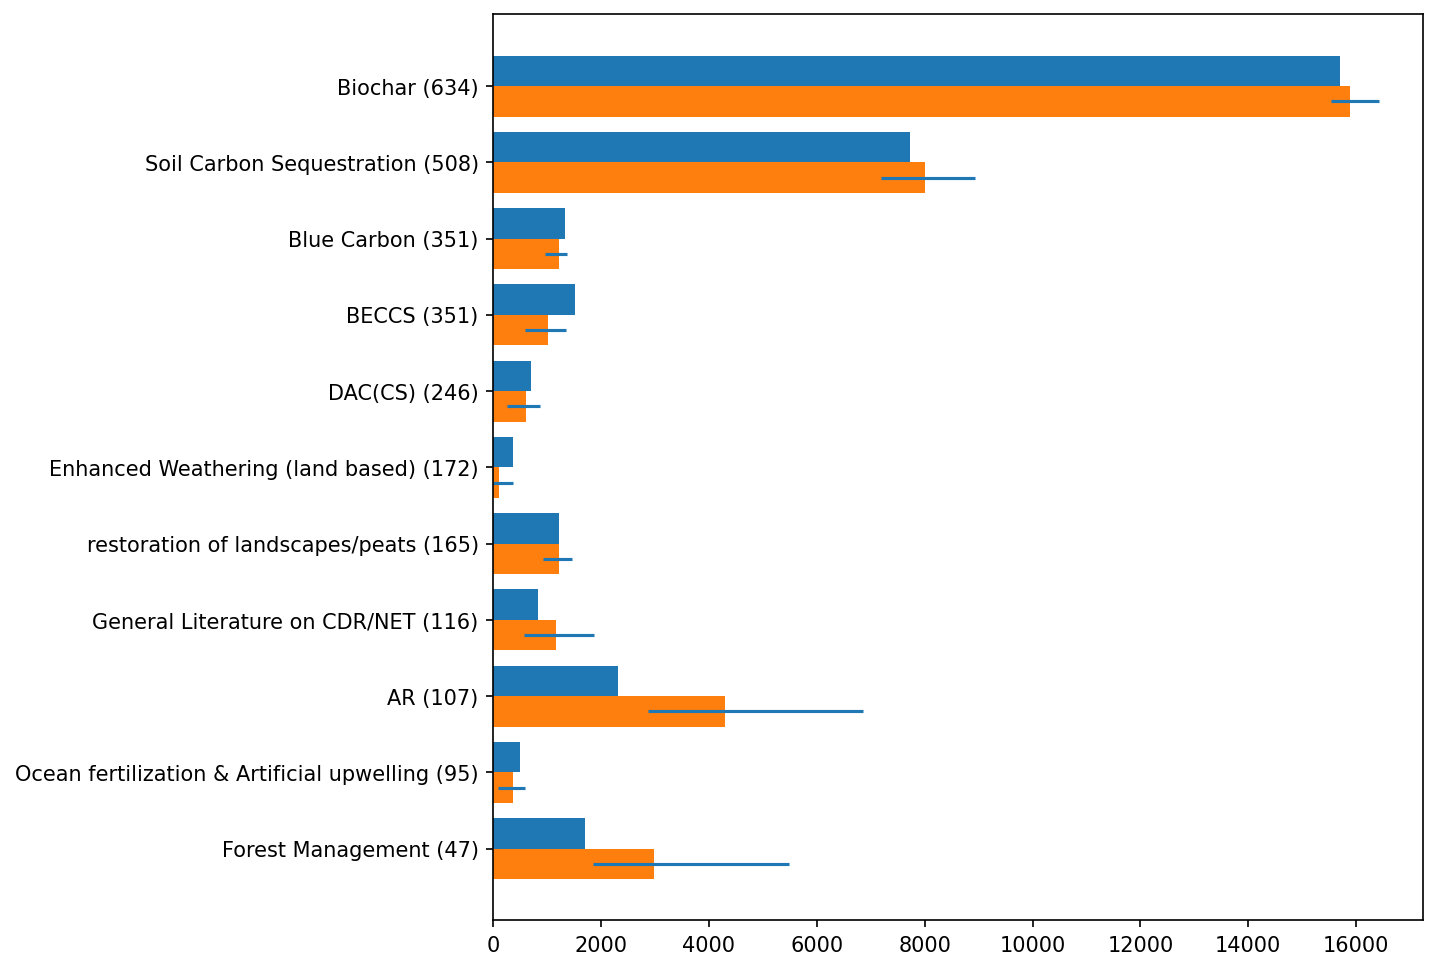

In [25]:


fig, ax = plt.subplots(figsize=(8,8), dpi=150)

ax.barh(df.index+0.2, df['predicted counts'], height=0.4)
ax.barh(df.index-0.2, df['count_acc'], height=0.4)

err = np.zeros((2, df.shape[0]))

err[0,:] = df['count_acc'] - (df['p_acc_l']*N)
err[1,:] = (df['p_acc_h']*N) - df['count_acc'] 

ax.errorbar(df['count_acc'], df.index-0.2, xerr=err, fmt='none')

ax.set_yticks(df.index)
ax.set_yticklabels(df['Main Focus'] + " (" + df['Number of Samples'].astype(str) + ')')

plt.savefig('plots/quantities.pdf', bbox_inches='tight')